In [2]:
import biorsp as rsp
import matplotlib.pyplot as plt
import numpy as np

/Users/cytronicoder/Downloads/biorsp_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = rsp.load_data("data/dge/NeonatalHeart_1_dge.txt", transpose=True, verbose=True)

Loading data from data/dge/NeonatalHeart_1_dge.txt as txt file...
Transposing data matrix.
Data loaded with shape: (10000, 19493).


In [4]:
adata = rsp.filter_data(
    adata,
    mito_prefix="mt-",
    min_genes=500,
    min_cells=1,
    verbose=True,
)
adata = rsp.dim_reduce(
    adata,
    method="tsne",
    verbose=1,
)
adata = rsp.dbscan_cluster(
    adata,
    method="tsne",
    eps=4.0,
    min_samples=50,
    verbose=1,
)

Performing quality control filtering...
Filtered cells: 1928 / 10000
Filtered genes: 16884 / 19493
Performing dimensionality reduction using TSNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1928 samples in 0.008s...


/Users/cytronicoder/Downloads/biorsp_package/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 1928 samples in 0.644s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1928
[t-SNE] Computed conditional probabilities for sample 1928 / 1928
[t-SNE] Mean sigma: 7.550453
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.079536
[t-SNE] KL divergence after 1000 iterations: 1.671180
Dimensionality reduction completed. Embedding saved to `.obsm['X_tsne']` with shape: (1928, 2)
Starting DBSCAN clustering using embedding 'X_tsne'...
DBSCAN clustering completed. 8 clusters found, 412 noise points.


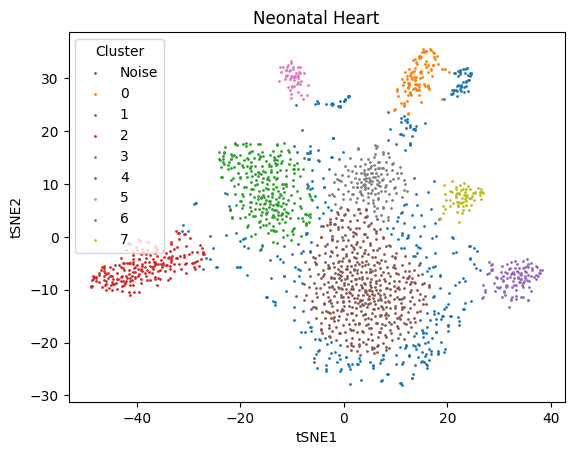

In [5]:
fig, ax = plt.subplots()
for i in np.unique(adata.obs["dbscan_cluster"]):
    ax.scatter(
        adata.obsm["X_tsne"][adata.obs["dbscan_cluster"] == i, 0],
        adata.obsm["X_tsne"][adata.obs["dbscan_cluster"] == i, 1],
        label=i if i != -1 else "Noise",
        s=1,
    )
ax.legend(title="Cluster")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.title("Neonatal Heart")
plt.show()

Genes of interest: Gpihbp1
Defining foreground cells using 1 gene(s) with thresholds [2].
Foreground cells identified: 215 / 1928.
Background cells identified: 1928 / 1928 (all points).


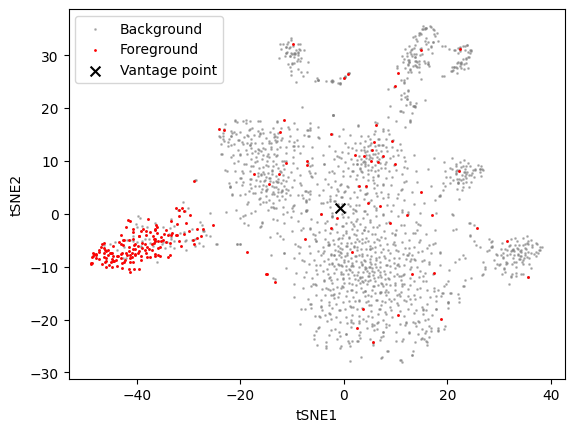

In [6]:
threshold = 2

while True:
    # genes_of_interest = np.random.choice(adata.var_names, 1)
    genes_of_interest = "Gpihbp1"

    fg_indices, bg_indices = rsp.define_foreground_and_background(
        adata, genes=genes_of_interest, threshold=threshold, mode="any", verbose=0
    )

    if 0.1 < len(fg_indices) / len(bg_indices) < 0.3:
        break

print(f"Genes of interest: {genes_of_interest}")

fg_indices, bg_indices = rsp.define_foreground_and_background(
    adata, genes=genes_of_interest, threshold=threshold, mode="any", verbose=1
)

fig, ax = plt.subplots()
foreground = adata.obsm["X_tsne"][fg_indices]
background = adata.obsm["X_tsne"][bg_indices]

vantage_point = rsp.set_vantage_point(background)

ax.scatter(
    background[:, 0], background[:, 1], label="Background", s=1, c="gray", alpha=0.5
)
ax.scatter(foreground[:, 0], foreground[:, 1], label="Foreground", s=1, c="red")
ax.scatter(
    vantage_point[0],
    vantage_point[1],
    label="Vantage point",
    s=50,
    c="black",
    marker="x",
)
ax.legend()
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()

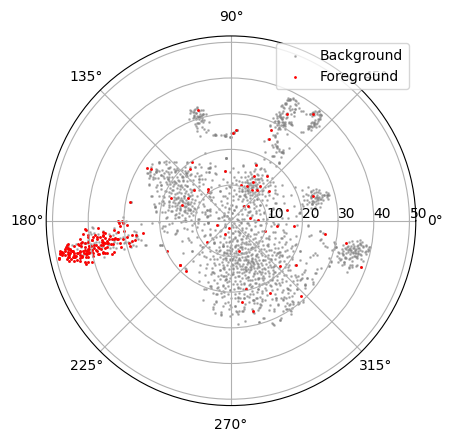

In [7]:
fg_r, fg_theta = rsp.transform_to_polar(foreground, vantage_point)
bg_r, bg_theta = rsp.transform_to_polar(background, vantage_point)

# polar plot
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.scatter(bg_theta, bg_r, label="Background", s=1, c="gray", alpha=0.5)
ax.scatter(fg_theta, fg_r, label="Foreground", s=1, c="red")

ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.grid(True)
ax.legend()
plt.show()

In [8]:
def plot_scanning_window(
    ax: plt.Axes, start_angle: float, end_angle: float, radius_max: float
) -> None:
    """
    Fill the scanning window region on a polar plot.
    """
    if start_angle < end_angle:
        theta_window: np.ndarray = np.linspace(start_angle, end_angle, 100)
    else:
        # Handle wrap-around case
        theta_window: np.ndarray = np.concatenate(
            (np.linspace(start_angle, 2 * np.pi, 50), np.linspace(0, end_angle, 50))
        )
    r_window: np.ndarray = np.full_like(theta_window, radius_max)
    theta_polygon: np.ndarray = np.concatenate(
        ([start_angle], theta_window, [end_angle], [start_angle])
    )
    r_polygon: np.ndarray = np.concatenate(([0], r_window, [0], [0]))
    ax.fill(
        theta_polygon, r_polygon, color="yellow", alpha=0.25, label="Scanning Window"
    )

In [9]:
central_angle = np.pi / 4
scanning_window = np.pi
scan_range = [0, 2 * np.pi]
resolution = 1000

In [ ]:
fg_within = rsp.within_window(fg_theta, central_angle, scanning_window)
bg_within = rsp.within_window(bg_theta, central_angle, scanning_window)

fg_hist, bg_hist, bin_edges, bin_centers = rsp.calculate_histograms(
    fg_theta, bg_theta, central_angle, scanning_window, resolution
)

norm_fg_hist, norm_bg_hist = rsp.normalize_histograms(fg_hist, bg_hist)
fg_cdf, bg_cdf = rsp.calculate_cdfs(norm_fg_hist, norm_bg_hist)

fig = plt.figure(figsize=(17.5, 5))
ax = [None, None, None]
fig.subplots_adjust(wspace=0.25)

ax[0] = plt.subplot(131, projection="polar")
ax[0].scatter(
    bg_theta[np.invert(bg_within)],
    bg_r[np.invert(bg_within)],
    s=1,
    c="gray",
    alpha=0.125,
)
ax[0].scatter(
    fg_theta[np.invert(fg_within)],
    fg_r[np.invert(fg_within)],
    s=1,
    c="red",
    alpha=0.25,
)
ax[0].scatter(bg_theta[bg_within], bg_r[bg_within], s=1, c="gray", alpha=0.5)
ax[0].scatter(fg_theta[fg_within], fg_r[fg_within], s=1, c="red")
plot_scanning_window(ax[0], central_angle - scanning_window / 2, central_angle + scanning_window / 2, np.max(fg_r))
ax[0].set_rlabel_position(0)
ax[0].grid(True)
ax[0].set_title(f"Central angle: {central_angle:.2f} rad")

# Second subplot: Bar plot
ax[1] = plt.subplot(132)
ax[1].bar(
    bin_centers,
    bg_hist,
    width=2 * np.pi / resolution,
    color="gray",
    alpha=0.5,
    label="Background",
)
ax[1].bar(
    bin_centers, fg_hist, width=2 * np.pi / resolution, color="red", label="Foreground"
)
ax[1].set_xlabel("Angle (radians)")
ax[1].set_ylabel("Frequency")
ax[1].legend()
ax[1].set_title(f"Histogram ({central_angle:.2f} ± {scanning_window / 2:.2f} rad)")

# Third subplot: Line plot
ax[2] = plt.subplot(133)
ax[2].plot(bin_centers, bg_cdf, color="gray", label="Background")
ax[2].plot(bin_centers, fg_cdf, color="red", label="Foreground")
ax[2].set_xlabel("Angle (radians)")
ax[2].set_ylabel("Cumulative density")
ax[2].legend()
ax[2].set_title("Foreground and background CDFs")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def update(frame):
    central_angle = frame * (
        2 * np.pi / frames
    )  # Rotate the scanning window over frames
    fg_within = rsp.within_window(fg_theta, central_angle, scanning_window)
    bg_within = rsp.within_window(bg_theta, central_angle, scanning_window)

    fg_hist, bg_hist, _, bin_centers = rsp.calculate_histograms(
        fg_theta, bg_theta, central_angle, scanning_window, resolution
    )

    norm_fg_hist, norm_bg_hist = rsp.normalize_histograms(fg_hist, bg_hist)
    fg_cdf, bg_cdf = rsp.calculate_cdfs(norm_fg_hist, norm_bg_hist)

    # Update polar plot
    ax[0].cla()
    ax[0].scatter(
        bg_theta[np.invert(bg_within)],
        bg_r[np.invert(bg_within)],
        s=1,
        c="gray",
        alpha=0.125,
    )
    ax[0].scatter(
        fg_theta[np.invert(fg_within)],
        fg_r[np.invert(fg_within)],
        s=1,
        c="red",
        alpha=0.25,
    )
    ax[0].scatter(bg_theta[bg_within], bg_r[bg_within], s=1, c="gray", alpha=0.5)
    ax[0].scatter(fg_theta[fg_within], fg_r[fg_within], s=1, c="red")
    plot_scanning_window(
        ax[0],
        central_angle - scanning_window / 2,
        central_angle + scanning_window / 2,
        np.max(fg_r),
    )
    ax[0].set_rlabel_position(0)
    ax[0].grid(True)
    ax[0].set_title(f"Central angle: {central_angle:.2f} rad")

    # Update histogram plot
    ax[1].cla()
    ax[1].bar(
        bin_centers,
        bg_hist,
        width=2 * np.pi / resolution,
        color="gray",
        alpha=0.5,
        label="Background",
    )
    ax[1].bar(
        bin_centers,
        fg_hist,
        width=2 * np.pi / resolution,
        color="red",
        label="Foreground",
    )
    ax[1].set_xlabel("Angle (radians)")
    ax[1].set_ylabel("Frequency")
    ax[1].legend()
    ax[1].set_title(f"Histogram ({central_angle:.2f} ± {scanning_window / 2:.2f} rad)")

    # Update CDF plot
    ax[2].cla()
    ax[2].plot(bin_centers, bg_cdf, color="gray", label="Background")
    ax[2].plot(bin_centers, fg_cdf, color="red", label="Foreground")
    ax[2].set_xlabel("Angle (radians)")
    ax[2].set_ylabel("Cumulative density")
    ax[2].legend()
    ax[2].set_title("Foreground and background CDFs")


frames = 100
fig = plt.figure(figsize=(17.5, 5))
ax = [plt.subplot(131, projection="polar"), plt.subplot(132), plt.subplot(133)]
fig.subplots_adjust(wspace=0.25)
animation = FuncAnimation(fig, update, frames=frames, interval=100, repeat=True)
animation.save("animation.gif", writer="pillow", fps=10)
plt.show()

In [ ]:
fg_hist = np.asarray(fg_hist)
bg_hist = np.asarray(bg_hist)

n_f = len(fg_theta)
n_b = len(bg_theta)

expected_foreground = bg_hist * (n_f / n_b)
rsp_abs_bin = fg_hist - expected_foreground

if n_f > 0:
    cdf_f = np.cumsum(fg_hist) / n_f
    cdf_expected_foreground = np.cumsum(expected_foreground) / n_f
else:
    cdf_f = np.zeros_like(fg_hist)
    cdf_expected_foreground = np.zeros_like(expected_foreground)

area_cdf_diff = np.trapz(
    np.abs(cdf_f - cdf_expected_foreground), dx=1.0 / len(cdf_f)
)

fig, ax = plt.subplots(1, 3, figsize=(17.5, 5))

ax[0].bar(bin_centers, bg_hist, width=2 * np.pi / resolution, color="gray", alpha=0.5, label="Background")
ax[0].bar(bin_centers, expected_foreground, width=2 * np.pi / resolution, color="blue", label="Expected foreground")
ax[0].bar(bin_centers, fg_hist, width=2 * np.pi / resolution, color="red", label="Foreground")
ax[0].set_xlabel("Angle (radians)")
ax[0].set_ylabel("Frequency")
ax[0].legend()

ax[1].bar(bin_centers, rsp_abs_bin, width=2 * np.pi / resolution, color="black")
ax[1].set_xlabel("Angle (radians)")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals")

ax[2].plot(bin_centers, cdf_expected_foreground, color="black", label="Expected foreground")
ax[2].plot(bin_centers, cdf_f, color="red", label="Foreground")
ax[2].fill_between(
    bin_centers,
    cdf_expected_foreground,
    cdf_f,
    where=np.abs(cdf_f - cdf_expected_foreground) > 0,
    color="red",
    alpha=0.25,
    label="Difference",
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
ax[2].text(
    0.05,
    0.95,
    f"Area = {area_cdf_diff:.2f}",
    transform=ax[2].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=props,
)
ax[2].set_xlabel("Angle (radians)")
ax[2].set_ylabel("Cumulative density")
ax[2].legend()
ax[2].set_title("Foreground and expected foreground CDFs")

plt.show()

Frame: 0, Central angle: 0.00 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 0, Central angle: 0.00 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 1, Central angle: 0.06 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 2, Central angle: 0.13 rad; Residual sum: 0.19, CDF diff: 0.33
Frame: 3, Central angle: 0.19 rad; Residual sum: 0.19, CDF diff: 0.33
Frame: 4, Central angle: 0.25 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 5, Central angle: 0.31 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 6, Central angle: 0.38 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 7, Central angle: 0.44 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 8, Central angle: 0.50 rad; Residual sum: 0.18, CDF diff: 0.33
Frame: 9, Central angle: 0.57 rad; Residual sum: 0.19, CDF diff: 0.33
Frame: 10, Central angle: 0.63 rad; Residual sum: 0.19, CDF diff: 0.33
Frame: 11, Central angle: 0.69 rad; Residual sum: 0.20, CDF diff: 0.33
Frame: 12, Central angle: 0.75 rad; Residual sum: 0.20, CDF diff: 0.33
Frame: 13, Centra

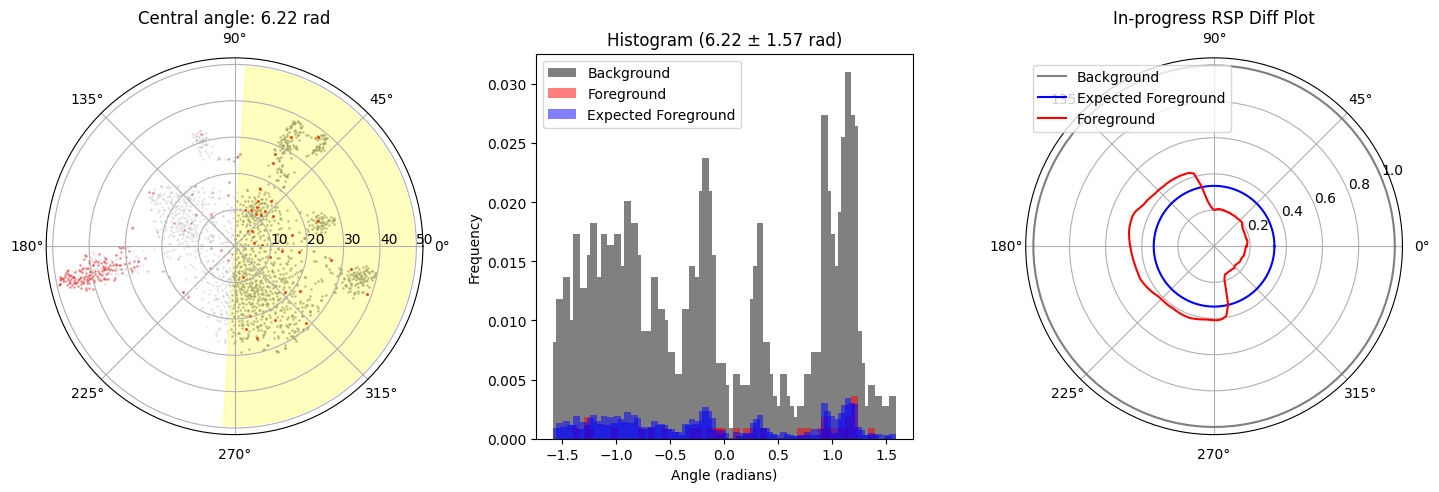

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

resolution = 100
rsp_diffs = np.zeros(resolution)
exp_rsp_diffs = np.zeros(resolution)
bg_rsp_diffs = np.zeros(resolution)

angles = np.linspace(0, 2 * np.pi, resolution)


def update(frame):
    central_angle = frame * (2 * np.pi / resolution)
    fg_within = rsp.within_window(fg_theta, central_angle, scanning_window)
    bg_within = rsp.within_window(bg_theta, central_angle, scanning_window)

    fg_hist, bg_hist, _, bin_centers = rsp.calculate_histograms(
        fg_theta, bg_theta, central_angle, scanning_window, resolution
    )

    fg_hist = np.asarray(fg_hist)
    bg_hist = np.asarray(bg_hist)

    fg_hist = fg_hist / np.sum(bg_hist)
    bg_hist = bg_hist / np.sum(bg_hist)
    
    exp_fg_hist = bg_hist * (len(fg_theta) / len(bg_theta))

    exp_rsp_diffs[frame] = np.sqrt(np.sum(exp_fg_hist))
    rsp_diffs[frame] = np.sqrt(np.sum(fg_hist))
    bg_rsp_diffs[frame] = np.sqrt(np.sum(bg_hist))

    print(
        f"Frame: {frame}, Central angle: {central_angle:.2f} rad; Residual sum: {rsp_diffs[frame]:.2f}, CDF diff: {exp_rsp_diffs[frame]:.2f}"
    )

    # Update Polar Plot
    ax[0].cla()
    ax[0].scatter(
        bg_theta[np.invert(bg_within)],
        bg_r[np.invert(bg_within)],
        s=1,
        c="gray",
        alpha=0.125,
    )
    ax[0].scatter(
        fg_theta[np.invert(fg_within)],
        fg_r[np.invert(fg_within)],
        s=1,
        c="red",
        alpha=0.25,
    )
    ax[0].scatter(bg_theta[bg_within], bg_r[bg_within], s=1, c="gray", alpha=0.5)
    ax[0].scatter(fg_theta[fg_within], fg_r[fg_within], s=1, c="red")
    plot_scanning_window(
        ax[0],
        central_angle - scanning_window / 2,
        central_angle + scanning_window / 2,
        np.max(fg_r),
    )
    ax[0].set_rlabel_position(0)
    ax[0].grid(True)
    ax[0].set_title(f"Central angle: {central_angle:.2f} rad")

    # Update Histogram Plot
    ax[1].cla()
    ax[1].bar(
        bin_centers,
        bg_hist,
        width=2 * np.pi / resolution,
        color="gray",
        label="Background",
    )
    ax[1].bar(
        bin_centers,
        fg_hist,
        width=2 * np.pi / resolution,
        color="red",
        alpha=0.5,
        label="Foreground",
    )
    ax[1].bar(
        bin_centers,
        exp_fg_hist,
        width=2 * np.pi / resolution,
        color="blue",
        alpha=0.5,
        label="Expected Foreground",
    )
    ax[1].set_xlabel("Angle (radians)")
    ax[1].set_ylabel("Frequency")
    ax[1].legend()
    ax[1].set_title(f"Histogram ({central_angle:.2f} ± {scanning_window / 2:.2f} rad)")

    # Update RSP Plot
    ax[2].cla()
    ax[2].set_title("In-progress RSP Diff Plot")
    ax[2].plot(
        angles[: frame + 1], bg_rsp_diffs[: frame + 1], color="gray", label="Background"
    )
    ax[2].plot(
        angles[: frame + 1],
        exp_rsp_diffs[: frame + 1],
        color="blue",
        label="Expected Foreground",
    )
    ax[2].plot(
        angles[: frame + 1], rsp_diffs[: frame + 1], color="red", label="Foreground"
    )
    ax[2].legend()
    # ax[2].set_ylim(0, 1)
    ax[2].grid(True)


fig = plt.figure(figsize=(17.5, 5))
ax = [
    plt.subplot(131, projection="polar"),
    plt.subplot(132),
    plt.subplot(133, projection="polar"),
]

fig.subplots_adjust(wspace=0.3, hspace=0.4)

animation = FuncAnimation(fig, update, frames=resolution, interval=100, repeat=True)
animation.save("animation.gif", writer="pillow", fps=10)

delta_theta = 2 * np.pi / resolution
bg_area = 0.5 * np.sum(bg_rsp_diffs**2) * delta_theta
exp_area = 0.5 * np.sum(exp_rsp_diffs**2) * delta_theta
area = 0.5 * np.sum(rsp_diffs**2) * delta_theta

A1 = area / bg_area

delta_area = np.abs(rsp_diffs**2 - exp_rsp_diffs**2) * 0.5 * delta_theta
sum_delta_area = np.sum(delta_area)
A2 = sum_delta_area / exp_area

print(f"A1: {A1:.2f}, A2: {A2:.2f}")

plt.show()

/var/folders/g4/m4yltzqj0c79mflv15hj0b3w0000gn/T/ipykernel_1050/3524197580.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  intersection_area = np.trapz(fg_cdf - bg_cdf, bin_centers)
/var/folders/g4/m4yltzqj0c79mflv15hj0b3w0000gn/T/ipykernel_1050/3524197580.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bg_area = np.trapz(bg_cdf, bin_centers)


Frame: 0, Central angle: 0.00 rad; RSP Diff: -0.24
Frame: 0, Central angle: 0.00 rad; RSP Diff: -0.24
Frame: 1, Central angle: 0.06 rad; RSP Diff: -0.21
Frame: 2, Central angle: 0.13 rad; RSP Diff: -0.20
Frame: 3, Central angle: 0.19 rad; RSP Diff: -0.20
Frame: 4, Central angle: 0.25 rad; RSP Diff: -0.23
Frame: 5, Central angle: 0.31 rad; RSP Diff: -0.23
Frame: 6, Central angle: 0.38 rad; RSP Diff: -0.18
Frame: 7, Central angle: 0.44 rad; RSP Diff: -0.15
Frame: 8, Central angle: 0.50 rad; RSP Diff: -0.15
Frame: 9, Central angle: 0.57 rad; RSP Diff: -0.11
Frame: 10, Central angle: 0.63 rad; RSP Diff: -0.10
Frame: 11, Central angle: 0.69 rad; RSP Diff: -0.13
Frame: 12, Central angle: 0.75 rad; RSP Diff: -0.12
Frame: 13, Central angle: 0.82 rad; RSP Diff: -0.08
Frame: 14, Central angle: 0.88 rad; RSP Diff: -0.06
Frame: 15, Central angle: 0.94 rad; RSP Diff: -0.04
Frame: 16, Central angle: 1.01 rad; RSP Diff: -0.04
Frame: 17, Central angle: 1.07 rad; RSP Diff: -0.01
Frame: 18, Central angl

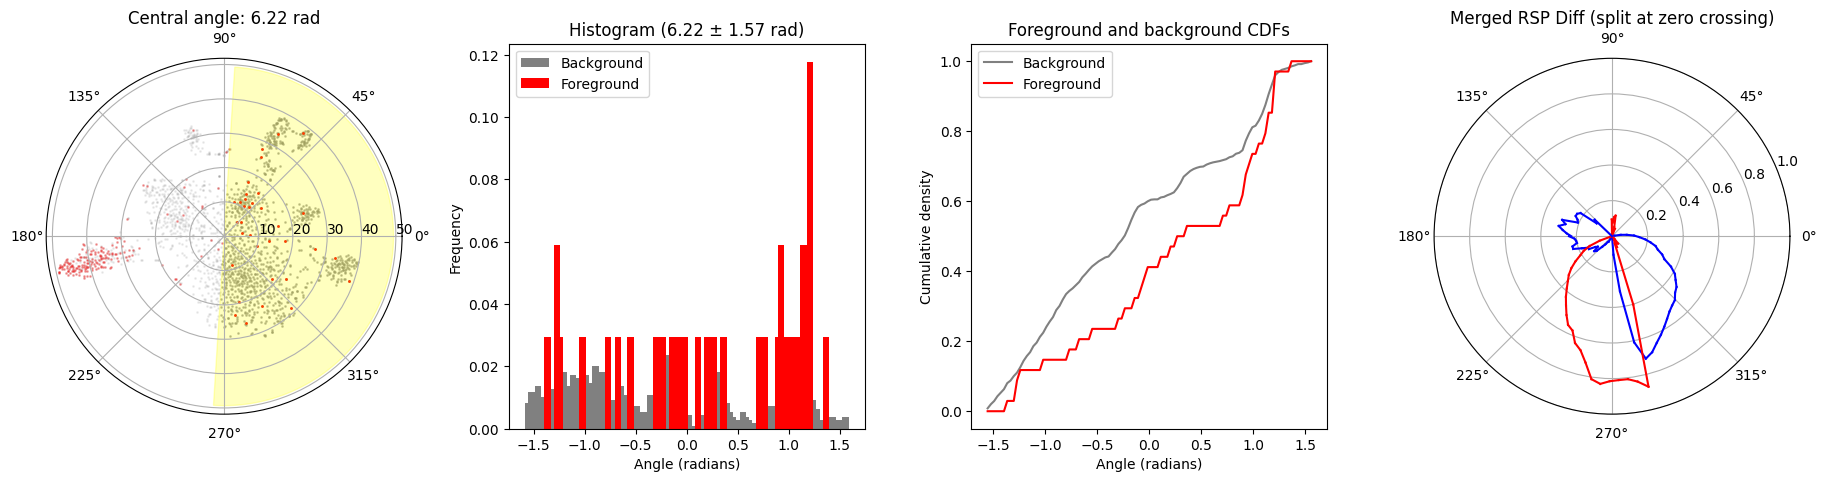

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

resolution = 100

central_angles = np.linspace(0, 2 * np.pi, resolution)
rsp_diffs = np.zeros(resolution)

angles = np.linspace(0, 2 * np.pi, resolution)


def update(frame):
    central_angle = frame * (2 * np.pi / resolution)
    fg_within = rsp.within_window(fg_theta, central_angle, scanning_window)
    bg_within = rsp.within_window(bg_theta, central_angle, scanning_window)

    fg_hist, bg_hist, _, bin_centers = rsp.calculate_histograms(
        fg_theta, bg_theta, central_angle, scanning_window, resolution
    )
    fg_hist, bg_hist = rsp.normalize_histograms(fg_hist, bg_hist)
    fg_cdf, bg_cdf = rsp.calculate_cdfs(fg_hist, bg_hist)

    # get the area between the two cdfs, with fg_cdf < bg_cdf being negative and fg_cdf > bg_cdf being positive area
    intersection_area = np.trapz(fg_cdf - bg_cdf, bin_centers)
    bg_area = np.trapz(bg_cdf, bin_centers)

    rsp_diffs[frame] = intersection_area / bg_area

    print(
        f"Frame: {frame}, Central angle: {central_angle:.2f} rad; RSP Diff: {rsp_diffs[frame]:.2f}"
    )

    # Update Polar Plot
    ax[0].cla()
    ax[0].scatter(
        bg_theta[np.invert(bg_within)],
        bg_r[np.invert(bg_within)],
        s=1,
        c="gray",
        alpha=0.125,
    )
    ax[0].scatter(
        fg_theta[np.invert(fg_within)],
        fg_r[np.invert(fg_within)],
        s=1,
        c="red",
        alpha=0.25,
    )
    ax[0].scatter(bg_theta[bg_within], bg_r[bg_within], s=1, c="gray", alpha=0.5)
    ax[0].scatter(fg_theta[fg_within], fg_r[fg_within], s=1, c="red")
    plot_scanning_window(
        ax[0],
        central_angle - scanning_window / 2,
        central_angle + scanning_window / 2,
        np.max(fg_r),
    )
    ax[0].set_rlabel_position(0)
    ax[0].grid(True)
    ax[0].set_title(f"Central angle: {central_angle:.2f} rad")

    # Update Histogram Plot
    ax[1].cla()
    ax[1].bar(
        bin_centers,
        bg_hist,
        width=2 * np.pi / resolution,
        color="gray",
        label="Background",
    )
    ax[1].bar(
        bin_centers,
        fg_hist,
        width=2 * np.pi / resolution,
        color="red",
        label="Foreground",
    )
    ax[1].set_xlabel("Angle (radians)")
    ax[1].set_ylabel("Frequency")
    ax[1].legend()
    ax[1].set_title(f"Histogram ({central_angle:.2f} ± {scanning_window / 2:.2f} rad)")

    # Update CDF Plot
    ax[2].cla()
    ax[2].plot(bin_centers, bg_cdf, color="gray", label="Background")
    ax[2].plot(bin_centers, fg_cdf, color="red", label="Foreground")
    ax[2].set_xlabel("Angle (radians)")
    ax[2].set_ylabel("Cumulative density")
    ax[2].legend()
    ax[2].set_title("Foreground and background CDFs")

    # Update RSP Plot
    ax[3].cla()
    ax[3].set_title("Merged RSP Diff (split at zero crossing)")

    def _plot_subsegment(ax, seg_points, color_by_sign):
        """
        seg_points: list of (theta, r) pairs
        color_by_sign: a float that determines color (if >=0 => red, else blue)
        """
        color = "red" if color_by_sign >= 0 else "blue"

        thetas = [p[0] for p in seg_points]
        rs = [p[1] for p in seg_points]

        if color_by_sign < 0:
            # Shift angles and flip radius
            thetas = [t + np.pi for t in thetas]
            rs = [-r for r in rs]

        ax.plot(thetas, rs, color=color)

    num_points = len(angles)
    for i in range(num_points - 1):
        r_i = rsp_diffs[i]
        r_ip1 = rsp_diffs[i + 1]

        th_i = angles[i]
        th_ip1 = angles[i + 1]

        # We'll build a list of "sub-segment" points, starting with (th_i, r_i)
        seg_points = [(th_i, r_i)]

        # 1) Check if sign changes within i->i+1
        if r_i * r_ip1 < 0:
            # There's a sign crossing between these two
            # Solve for zero crossing with linear interpolation
            # r(t) = r_i + t*(r_ip1 - r_i), find t where r(t)=0
            t = -r_i / (r_ip1 - r_i)

            # Theta at crossing
            th_cross = th_i + t * (th_ip1 - th_i)

            # r at crossing is 0
            seg_points.append((th_cross, 0.0))

            # We'll finish the segment from crossing to i+1 as a second sub-segment
            # So we'll plot [ (th_i, r_i) -> (th_cross, 0) ] in the first color
            # Then separately [ (th_cross, 0) -> (th_ip1, r_ip1) ] in the second color
            # So seg_points is for the first sub-segment
            # Then we manually do the second sub-segment next
            # We'll do the first sub-segment now:

            # Plot sub-segment #1
            _plot_subsegment(ax[3], seg_points, color_by_sign=r_i)

            # Now sub-segment #2: from crossing to (th_ip1, r_ip1)
            seg_points_2 = [(th_cross, 0.0), (th_ip1, r_ip1)]
            _plot_subsegment(ax[3], seg_points_2, color_by_sign=r_ip1)

        else:
            # No sign crossing, just one sub-segment i->i+1
            seg_points.append((th_ip1, r_ip1))
            _plot_subsegment(ax[3], seg_points, color_by_sign=0.5 * (r_i + r_ip1))

    ax[3].set_ylim(0, 1)
    ax[3].grid(True)

fig = plt.figure(figsize=(22.5, 5))
ax = [
    plt.subplot(141, projection="polar"),
    plt.subplot(142),
    plt.subplot(143),
    plt.subplot(144, projection="polar"),
]

fig.subplots_adjust(wspace=0.3, hspace=0.4)

animation = FuncAnimation(fig, update, frames=resolution, interval=100, repeat=True)

# save the two arrays to one csv
import pandas as pd

df = pd.DataFrame(
    {"angles": angles, "rsp_diffs": rsp_diffs}
)
df.to_csv("rsp_diffs.csv", index=False)

animation.save("animation.gif", writer="pillow", fps=10)

plt.show()